## 1. Overview
Cookie Cats is a mobile puzzle game developed by Tactile Entertainment. It's a "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level.

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in the player's enjoyment of the game being increased and prolonged.

The product team is interested in using these gates to optimize 1 and 7-day retention. Crucially, they wanted to know where in the player's experience should the gates be placed. 

Initially the first gate was placed at level 30. In this notebook I will analyze an AB-test where the first gate in Cookie Cats was moved from level 30 to level 40. 

In [10]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt

# Reading in the data
df = pd.read_csv('datasets/cookie_cats.csv')

# Showing the first few rows
display(df.head())

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 2. The AB-test data
The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>

When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. 

Confirming group assignment:

In [6]:
# Counting the number of players in each AB group.
version_count = df['version'].value_counts()

print(version_count)

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64


## 3. The distribution of game rounds
There is roughly the same number of players in each group.

To better understand player behavior, we first plot the distribution of the number of game rounds players played during their first week playing the game.

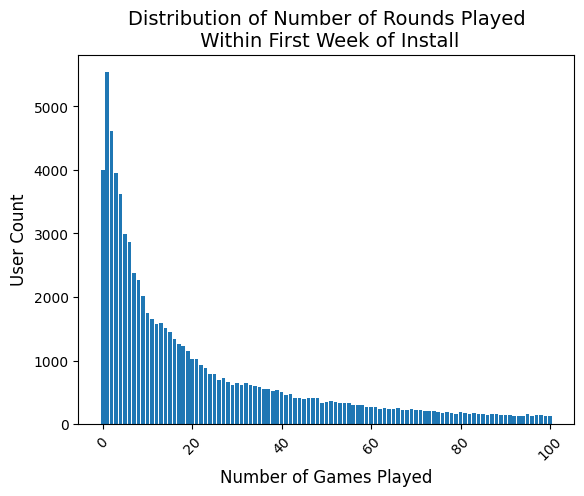

Distribution of Users by Number of Games Played:
   Number of Games Played  User Count
0                    0-19       77673
1                 100-119        7244
2                 200-219        2580
3                 300-319        1230
4                 400-419         602
..                    ...         ...
95              5100-5119           0
96              4900-4919           0
97              4800-4819           0
98              4700-4719           0
99              5000-5019           0

[100 rows x 2 columns]


In [13]:
# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds').size().reset_index(name="user_count")

# Subset to 100 rounds or fewer
plot_df_subset = plot_df.loc[plot_df['sum_gamerounds'] < 101]

# Plotting the distribution of players that played 0 to 100 game rounds
plt.figure('histogram')
plt.bar(plot_df_subset['sum_gamerounds'], plot_df_subset['user_count'])
plt.xlabel('Number of Games Played', fontsize=12)
plt.ylabel('User Count', fontsize=12)
plt.title('Distribution of Number of Rounds Played\n Within First Week of Install', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Create Bins
bins = list(range(0, 10000, 100)) + [float('inf')]  
labels = [f'{i}-{i+19}' if i<10000 else '1000+' for i in bins[:-1]]
# Create a new column for assigned bin labels
df['Binned_Rounds'] = pd.cut(df['sum_gamerounds'], bins=bins, labels=labels, right=False)

# Aggregate the data by the new binned column
distribution_table = df['Binned_Rounds'].value_counts().reset_index()

# Rename columns
distribution_table.columns = ['Number of Games Played', 'User Count']

# Display the summary table
print("Distribution of Users by Number of Games Played:")
print(distribution_table)


## 4. Overall 1-day retention
The plot above demonstrates some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some play more than 50 rounds in their first week.

To further examine engagement, I isolate 1-day retention</em>: The percentage of players that comes back and plays the game <em>one day</em> after they have installed it.  The higher 1-day retention is, the easier it is to retain players and build a large player base. 

As a first step, let's look at what 1-day retention is overall.

In [24]:
# It looks like there are some users with extremely high round amounts. Perhaps bots? Perhaps errors? 
# Winsorize to recode as 99th percentile users

from scipy.stats.mstats import winsorize

# Winsorize at the 99th percentile on the right tail
df['winsorized_sum_gamerounds'] = winsorize(df['sum_gamerounds'], limits=[0, 0.01]) 

# Display a summary of winsorized and original values for comparison
print("Original 'sum_gamerounds' Summary:")
print(df['sum_gamerounds'].describe())

print("\nWinsorized 'sum_gamerounds' Summary:")
print(df['winsorized_sum_gamerounds'].describe())

# The % of users that came back the day after they installed
one_day_retention = df['retention_1'].sum() / df['retention_1'].count()


print(f'1-Day Retention: {round(one_day_retention,3)*100}%')

Original 'sum_gamerounds' Summary:
count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

Winsorized 'sum_gamerounds' Summary:
count    90189.000000
mean        48.993647
std         84.205426
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max        493.000000
Name: winsorized_sum_gamerounds, dtype: float64
1-Day Retention: 44.5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


## 5. 1-day retention by AB-group
44.5% of players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups.

In [50]:
# Calculating 1-day retention for each AB-group
one_day_retention = df['retention_1'].groupby(df['version']).sum() / df['retention_1'].groupby(df['version']).count()

print(f'1-Day Retention for Gate 30 is: {round(one_day_retention['gate_30'],3)*100}%')
print(f'1-Day Retention for Gate 40 is: {round(one_day_retention['gate_40'],3)*100}%')

1-Day Retention for Gate 30 is: 44.800000000000004%
1-Day Retention for Gate 40 is: 44.2%


## 6. Confidence in group differences
There was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact. But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?

There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

Index(['gate_30', 'gate_40'], dtype='object', name='version')


<Figure size 640x480 with 0 Axes>

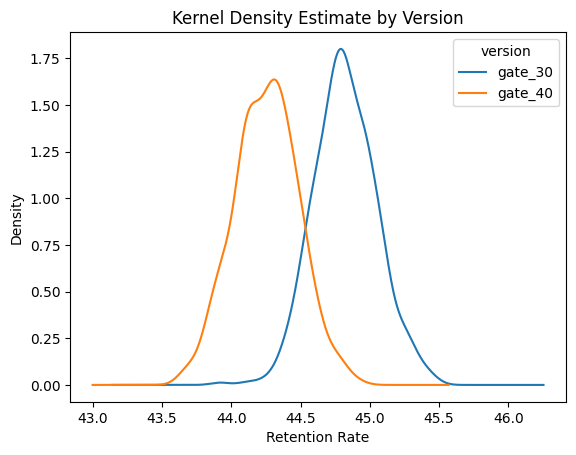

In [58]:
# Creating an list with bootstrapped means for each AB-group
iterations = 500
boot_1d = []

for i in range(iterations):
    boot_mean = df['retention_1'].sample(frac=1, replace=True).groupby(df['version']).mean()
    boot_1d.append(boot_mean)

# Transforming the list to a DataFrame
boot_1d_df = pd.DataFrame(boot_1d)
print(boot_1d_df.columns)

# Putting on 1 to 100 scale
boot_1d_df['gate_30'] = boot_1d_df['gate_30'] * 100
boot_1d_df['gate_40'] = boot_1d_df['gate_40'] * 100

# A Kernel Density Estimate plot of the bootstrap distributions
plt.figure('KDE')
boot_1d_df.plot(kind='kde')
plt.title('Kernel Density Estimate by Version')
plt.xlabel('Retention Rate')
plt.ylabel('Density')
plt.show()

## 7. Zooming in on the difference
These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. Let's zoom in on the difference in 1-day retention.

Note that in this notebook I have limited the number of bootstrap replication to 500 to keep the calculations quick. 

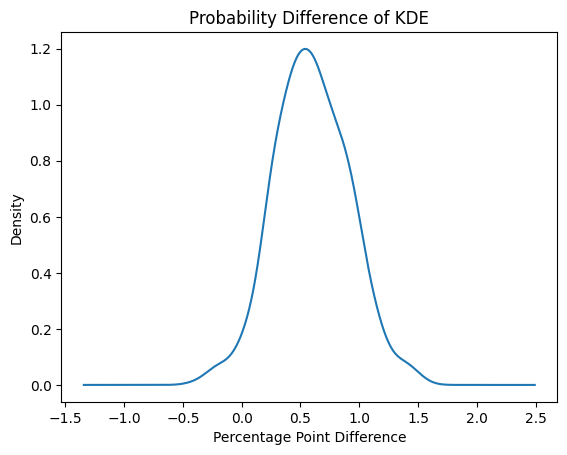

In [57]:
# Adding a column with the % difference between the two AB-groups
boot_1d_df['diff'] = boot_1d_df['gate_30']-boot_1d_df['gate_40']

# Ploting the bootstrap % difference
plt.figure('distribution_diff')
boot_1d_df['diff'].plot(kind='kde')
plt.title('Probability Difference of KDE')
plt.xlabel('Percentage Point Difference')
plt.ylabel('Density')
plt.show()

## 8. The probability of a difference
From this chart, we can see that the most likely % difference is around 0% - 1%, and that most of the distribution is above 0%, in favor of a gate at level 30. But what is the <em>probability</em> that the difference is above 0%? Let's calculate that as well.

In [48]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob_1d = (boot_1d_df['diff'] >0).sum()/(boot_1d_df['diff']).count()

print('{:.1%}'.format(prob_1d))

96.6%


## 9. 7-day retention by AB-group
The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30.

But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.

Let's start by calculating 7-day retention for the two AB-groups.

In [52]:
# Calculating 7-day retention for both AB-groups
seven_day_retention = df['retention_7'].groupby(df['version']).sum() / df['retention_7'].groupby(df['version']).count()


print(f'7-Day Retention for Gate 30 is: {round(seven_day_retention['gate_30'],3)*100}%')
print(f'7-Day Retention for Gate 40 is: {round(seven_day_retention['gate_40'],3)*100}%')

7-Day Retention for Gate 30 is: 19.0%
7-Day Retention for Gate 40 is: 18.2%


## 10. Bootstrapping the difference again
Similar to 1-day retention, 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. 

Overall 7-day retention is lower than the overall 1-day retention; fewer people play a game a week after installing than a day after installing.

But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.

Index(['gate_30', 'gate_40'], dtype='object', name='version')


<Figure size 640x480 with 0 Axes>

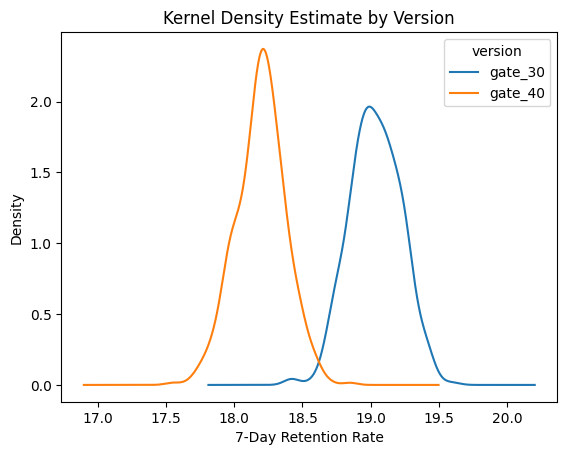

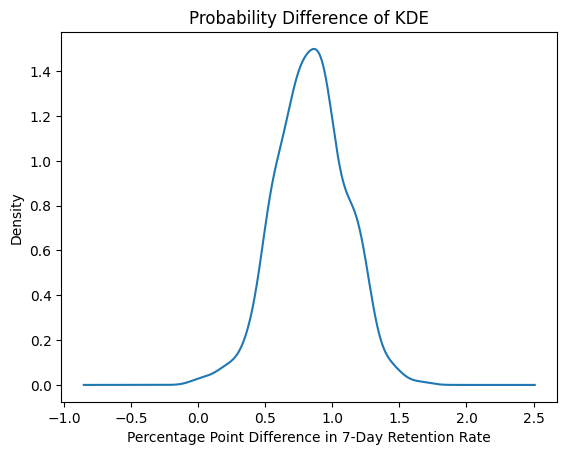

99.8%


In [59]:
# Creating a list with bootstrapped means for each AB-group
iterations = 500
boot_7d = []

for i in range(iterations):
    boot_mean = df['retention_7'].sample(frac=1, replace=True).groupby(df['version']).mean()
    boot_7d.append(boot_mean)

# Transforming the list to a DataFrame
boot_7d_df = pd.DataFrame(boot_7d)
print(boot_7d_df.columns)

# Putting on 0 to 100 scale
boot_7d_df['gate_30'] = boot_7d_df['gate_30'] * 100
boot_7d_df['gate_40'] = boot_7d_df['gate_40'] * 100

# A Kernel Density Estimate plot of the bootstrap distributions
plt.figure('KDE 7-Day')
boot_7d_df.plot(kind='kde')
plt.title('Kernel Density Estimate by Version')
plt.xlabel('7-Day Retention Rate')
plt.ylabel('Density')
plt.show()

# Adding a column with the % difference between the two AB-groups
boot_7d_df['diff'] = boot_7d_df['gate_30']-boot_7d_df['gate_40']

# Ploting the bootstrap % difference
plt.figure('Distribution Diff 7-Day')
boot_7d_df['diff'].plot(kind='kde')
plt.title('Probability Difference of KDE')
plt.xlabel('Percentage Point Difference in 7-Day Retention Rate')
plt.ylabel('Density')
plt.show()

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob_7d = (boot_7d_df['diff'] > 0).sum() / (boot_7d_df['diff']).count()

# Pretty printing the probability
print('{:.1%}'.format(prob_7d))

## 11.  Conclusion
The bootstrap result suggests there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. 

If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.